This notebook shows proof-of-principle merge correction on two falsely merged parallel fibers implemented in the `error_correction` module. The method is based on racking connected components from slice ot slice using an estimate for the flow vector from the object skeleton.. Merge correction works best on the segmentation with highest lateral resolution, in our case 8 nm x 8 nm x 30 nm.

In [1]:
from cerebellum.utils.data_io import *
import json

# json file with segmentation params and file locations
with open('data_locs.json') as f:
	data_locs = json.load(f)
block_index = 0 # TO CHANGE: which block you are processing
zz = data_locs["block-size"]*block_index+14

# load segmentation
seg_prefix = 'pred-pf-8nm-crop2gt-%04d'%(zz) # folder with segmentation
seg_res = (30,8,8)
seg_file = './segs/'+seg_prefix+'/seg.h5'
seg = read3d_h5(seg_file,'main') # load segmentation
print seg.shape

# load skeletons
from cerebellum.ibex.utilities.dataIO import ReadSkeletons
skel_prefix = "pred-all" # folder with skeletons
output_resolution=(80,80,80) # downsampled resolution before skeletonization
skeletons = ReadSkeletons(skel_prefix, downsample_resolution=output_resolution, read_edges=True)

/home/srujanm/anaconda2/envs/em/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(90, 3198, 2930)


In [2]:
test_id = 2252 # TO CHANGE: ID of a falsely merged object

# generate object mask
from cerebellum.utils.mask import *
shape_mask, bbox = mask_in_bbox(seg, test_id)
print shape_mask.shape
print bbox
# get skeleton of object to be corrected
skel = skeletons[test_id]

(90, 156, 136)
(0L, 189L, 1791L, 90L, 345L, 1927L)


In [3]:
# initiaize merge correction
from cerebellum.error_correction.split_obj import *
test_split = SplitObject(shape_mask, seg_res, bbox, skel)

As a first step go through each slice and label the connected components

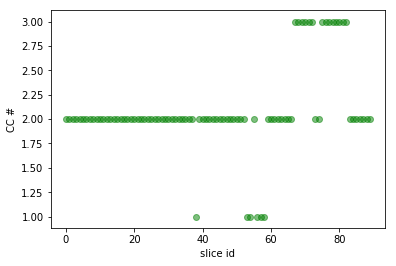

In [4]:
# generate connected components per slice
fpath = './err-correction/'+seg_prefix # save all error correction results to this folder
create_folder(fpath)
label_path = fpath+'/labeled-obj-mask-8nm-%d/'%(test_id)+'/'
create_folder(label_path)
test_split.label_slices(connectivity=2, 
                        save_plots_path=label_path)
test_split.plot_ncc()

Based on the above plot, the method then identifies "fill neighborhoods", i.e. intervals of slice indices where correction needs to be performed, and slices need to be filled with the correct color. The direction of tracking is from the left slice ID in the neighborhood to the right slice ID generated below, and is such that the left slice has more connectd components in it.

In [5]:
# generate fill neighborhoods
test_split.find_fill_nbds()
print test_split.fill_nbds

[[67, 0], [72, 73], [75, 74], [82, 89]]


Here, we visualize one step of the split procedure going from a correct slice (the 'pivot slice') to the incorrect slice (the 'fill slice')

Pivot points for propagation: [array([ 56, 105]), array([74, 83]), array([101,  88])]
Flow vectors: [[1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666]]
Seed locs: [(56, 104), (74, 82), (101, 87)]


cerebellum/error_correction/skel_flow.py:33: RuntimeWarning: divide by zero encountered in divide
  edge_vecs = [np.divide(edge_vec, float(edge_vec[0])) for edge_vec in edge_vecs] # normalize such that z-comp is 1
cerebellum/error_correction/skel_flow.py:33: RuntimeWarning: invalid value encountered in divide
  edge_vecs = [np.divide(edge_vec, float(edge_vec[0])) for edge_vec in edge_vecs] # normalize such that z-comp is 1


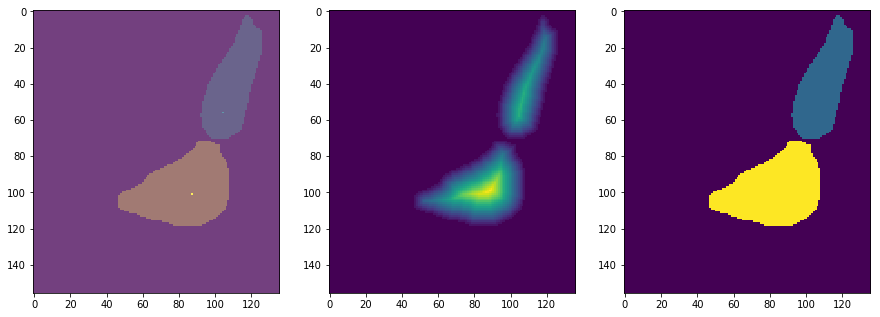

In [6]:
# test split_slice individually
from cerebellum.error_correction.split_slice import *

pivot_id = 82 # correct slice
f = 1 # flow dir
fill_id = pivot_id + f # ID of slice to work on
filled_slice, filled_ccs = test_split.propagate_slice(pivot_id, fill_id, plot_seeds=True)

In this manner, you can iterate through each fill neighborhood and split up the object. Images of slices corrected in the operation below are saved for debugging.

In [7]:
split_path = fpath + '/split-obj-mask-8nm-%d/'%(test_id) + '/' # save results
create_folder(split_path)
test_split.fill_object(save_path=split_path)




76 slices left to fill


Inspecting neighborhood: [67, 0]

Tracking 67 and splitting 66 into 3 CCs
Pivot points for propagation: [array([ 71, 117]), array([86, 96]), array([114,  95])]
Flow vectors: [[1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666]]
Seed locs: [(70, 117), (85, 96), (113, 95)]

Tracking 66 and splitting 65 into 3 CCs
Pivot points for propagation: [array([ 66, 122]), array([90, 98]), array([116,  96])]
Flow vectors: [[1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666]]
Seed locs: [(65, 122), (89, 98), (115, 96)]

Tracking 65 and splitting 64 into 3 CCs
Pivot points for propagation: [array([ 66, 122]), array([90, 98]), array([116,  96])]
Flow vectors: [[1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.6666666666666666], [1.0, 0.3333333333333333, -0.666666666666